In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import ndimage
import skimage
import cv2
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = (10, 10)

# Start Analysis
Let's look at the images. How they look will guide, how I go about segmentation.

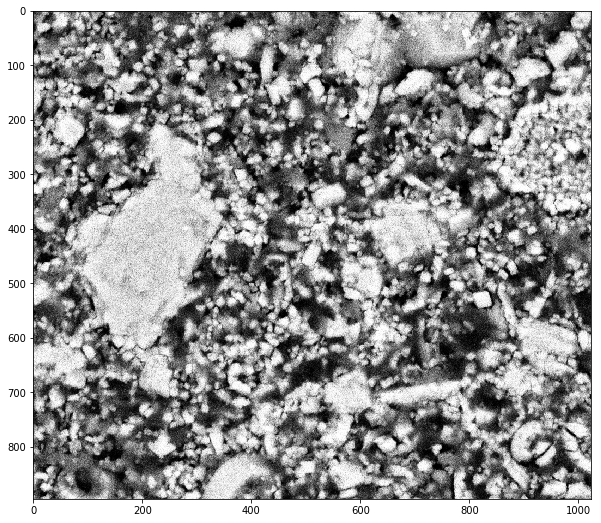

In [4]:
bsem = cv2.imread('bsem.png',0)
plt.imshow(bsem,'gray')
plt.show()

It's often important to smooth the data. We'll try a super simple Gaussian; possibly a Bilateral filter would also be good.

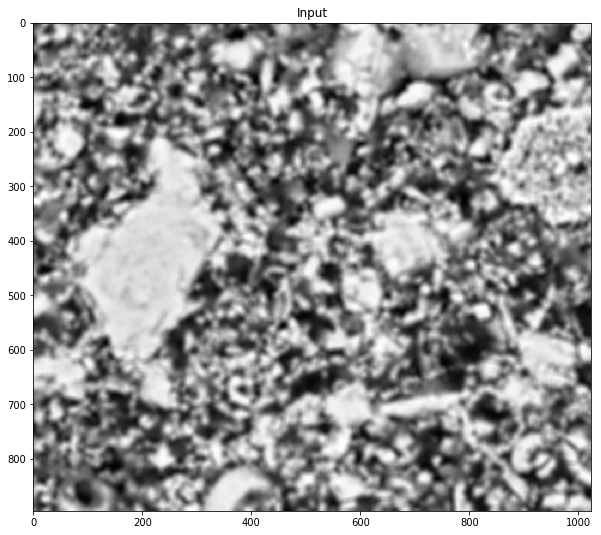

In [5]:
blurred = cv2.GaussianBlur(bsem,(11,11),15)
plt.imshow(blurred, 'gray')
plt.title('Input')
plt.show()

We can look at the histogram as well, to see if there are any obvious divisions we can apply.

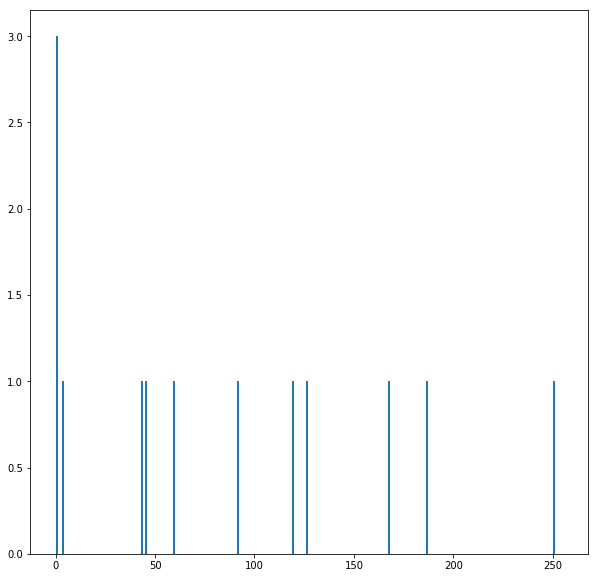

In [6]:
histogram = cv2.calcHist([blurred],[0],None,[256],[0,256])
hist_normalize = histogram.ravel()/histogram.max()
plt.hist(histogram, np.arange(256))
img = plt.gcf()
plt.show()

C:\Users\jdram\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jdram\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\jdram\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:20: RuntimeWarning: invalid value encountered in double_scalars


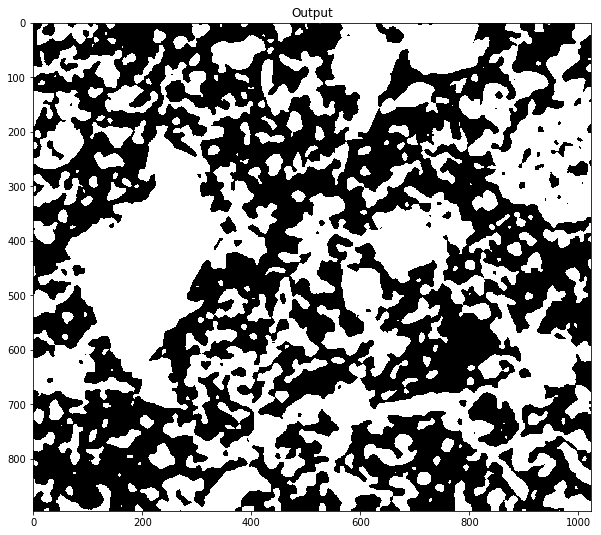

Threshold gotten by native implementation: 142
Threshold gotten by the OpenCV implementation: 141.0
Percentage error in calculation is 0.7092198581560284 %


In [7]:
Q = hist_normalize.cumsum()
x_axis = np.arange(256)
mini = np.inf
thresh = -1
for i in range(1,256):
    # probabilities
    p1,p2 = np.hsplit(hist_normalize,[i])

    # cumulative sum of classes
    q1,q2 = Q[i],Q[255]-Q[i]

    # weights
    b1,b2 = np.hsplit(x_axis,[i])

    # finding means and variances
    m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
    v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2

    # calculates the minimization function
    fn = v1*q1 + v2*q2
    if fn < mini:
        mini = fn
        thresh = i

# find otsu's threshold value with OpenCV function
ret, binarized = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Save the output image
cv2.imwrite("../Result/house_thresh.jpg", binarized)

plt.imshow(binarized, 'gray')
plt.title('Output')
plt.show()

print ("Threshold gotten by native implementation:",thresh)
print ("Threshold gotten by the OpenCV implementation:",ret)

print ("Percentage error in calculation is",abs(thresh-ret)/ret*100.0,"%")

Okay, cool. We see that we can do something with the histogram. The data is divided nicely. But it is somewhat too smooth.

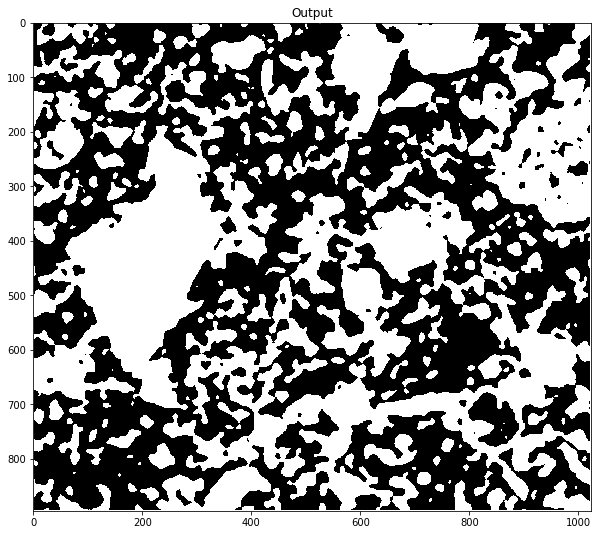

126 samples corrected for by morphological filtering.


In [8]:
eroded_img = ndimage.binary_erosion(binarized)
reconstruct_img = ndimage.binary_propagation(eroded_img, mask=ndimage.filters.gaussian_filter(binarized,10,order=2))
tmp = np.logical_not(reconstruct_img)
eroded_tmp = ndimage.binary_erosion(tmp)
reconstruct_final = np.logical_not(ndimage.binary_propagation(eroded_tmp, mask=ndimage.filters.gaussian_filter(tmp,10,order=2)))

plt.imshow(reconstruct_final, 'gray')
plt.title('Output')
plt.show()

print(int(np.abs(binarized - reconstruct_final).mean()), "samples corrected for by morphological filtering." )

126 samples corrected for by morphological filtering.


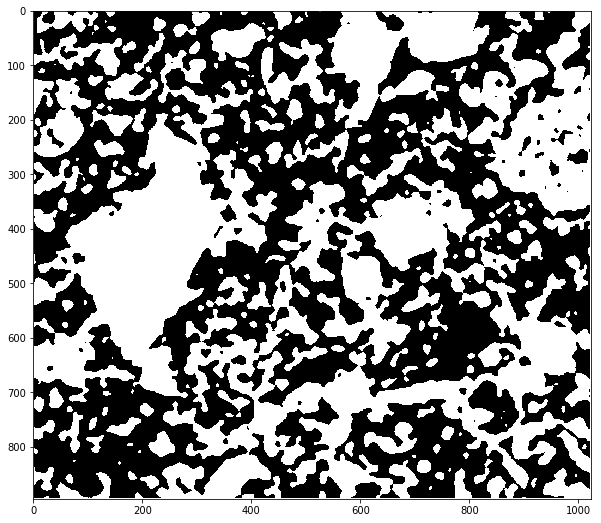

In [9]:
plt.imshow(binarized, 'gray')
plt.savefig('01.png', dpi = 200, bbox_inches='tight', pad_inches = 0)
eroded_img = ndimage.binary_erosion(binarized)
plt.imshow(eroded_img, 'gray')
plt.savefig('02.png', dpi = 200, bbox_inches='tight', pad_inches = 0)
reconstruct_img = ndimage.binary_propagation(eroded_img, mask=ndimage.filters.gaussian_filter(binarized,10,order=2))
plt.imshow(reconstruct_img, 'gray')
plt.savefig('03.png', dpi = 200, bbox_inches='tight', pad_inches = 0)
tmp = np.logical_not(reconstruct_img)
plt.imshow(tmp, 'gray')
plt.savefig('04.png', dpi = 200, bbox_inches='tight', pad_inches = 0)
eroded_tmp = ndimage.binary_erosion(tmp)
plt.imshow(np.invert(eroded_tmp), 'gray')
plt.savefig('05.png', dpi = 200, bbox_inches='tight', pad_inches = 0)
reconstruct_final = np.logical_not(ndimage.binary_propagation(eroded_tmp, mask=ndimage.filters.gaussian_filter(tmp,10,order=2)))

plt.imshow(reconstruct_final, 'gray')
plt.savefig('06.png', dpi = 200, bbox_inches='tight', pad_inches = 0)
print(int(np.abs(binarized - reconstruct_final).mean()), "samples corrected for by morphological filtering." )

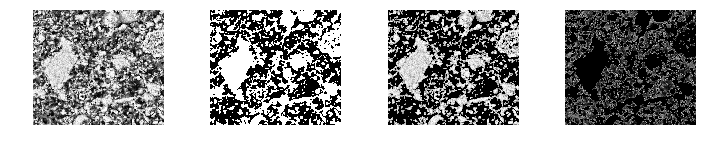

In [10]:
plt.subplot(141)
plt.imshow(bsem, cmap='gray')
plt.axis('off')
plt.subplot(142)
plt.imshow(binarized, cmap='gray')
plt.axis('off')
plt.subplot(143)
plt.imshow(bsem*reconstruct_final, cmap='gray')
plt.axis('off')
plt.subplot(144)
plt.imshow(bsem*np.invert(reconstruct_final), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig('hist_segmentation_small.png', dpi = 200, bbox_inches='tight', pad_inches = 0)
plt.show()

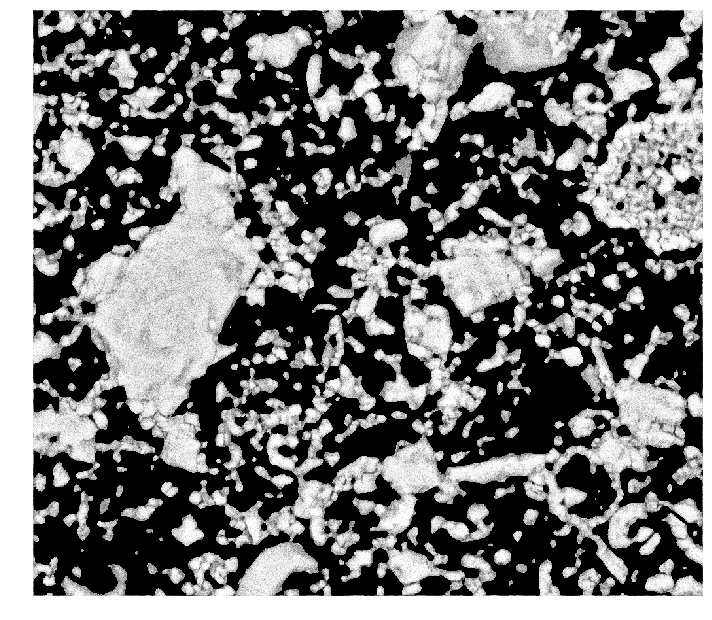

In [11]:
plt.imshow(bsem*reconstruct_final, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig('hist_segmentation.png', dpi = 200, bbox_inches='tight', pad_inches = 0)

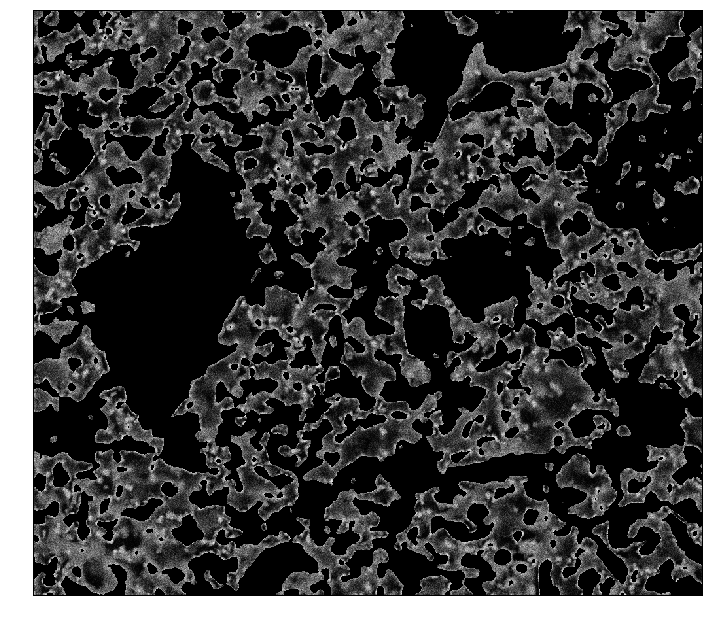

In [12]:
plt.imshow(bsem*np.invert(reconstruct_final), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig('hist_segmentation_out.png', dpi = 200, bbox_inches='tight', pad_inches = 0)

Morgphological filtering basically gets rid of noisy little sections and closes small holes. Generally, morphological tricks are our friend here.

# Gaussian Mixtures
The histogram doesn't seem to work too well. Given the histogram above, that makes sense. Let's try one model I personally quite like (and obviously I tried everything else and it failed...). We analyze our data and with the magic of machine learning, we shall find a separation of the foreground and the background.

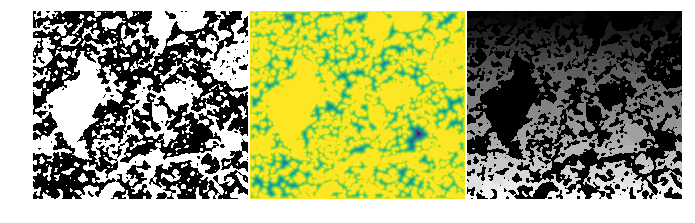

1.0381038188934326s passed.


In [13]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed
import time

t0 = time.time()
imag = np.invert(reconstruct_final)
distance = ndimage.distance_transform_edt(imag)
local_maxi = peak_local_max(
    distance, indices=False, footprint=np.ones((11, 11)), labels=imag)
markers = ndimage.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=imag)

plt.figure(figsize=(9, 3.5))
plt.subplot(131)
plt.imshow(reconstruct_final, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(132)
plt.imshow(-distance, interpolation='nearest')
plt.axis('off')
plt.subplot(133)
plt.imshow(labels, cmap='gray', interpolation='nearest')
plt.axis('off')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,
                    right=1)
plt.show()
print("{}s passed.".format(time.time()-t0))

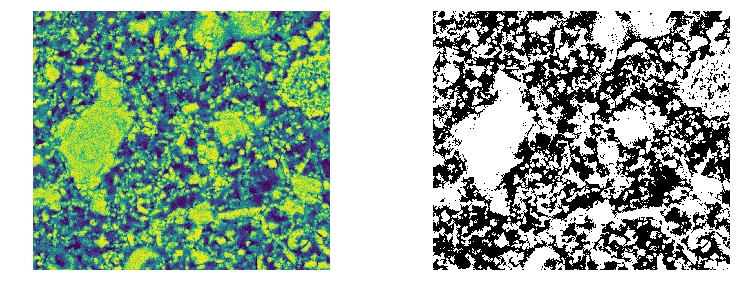

1.5561556816101074s passed


In [14]:
from sklearn.mixture import GaussianMixture

t0 = time.time()
classif = GaussianMixture(n_components=2)
classif.fit(bsem.reshape((bsem.size, 1)))

threshold = np.mean(classif.means_)
binary_img = bsem > threshold*.95

hist, bin_edges = np.histogram(bsem, bins=40)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])


plt.figure(figsize=(11,4))

plt.subplot(121)
plt.imshow(bsem)
plt.axis('off')
plt.subplot(122)
plt.imshow(binary_img, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')

plt.subplots_adjust(wspace=0.02, hspace=0.3, top=1, bottom=0.1, left=0, right=1)
plt.show()

print("{}s passed".format(time.time()-t0))

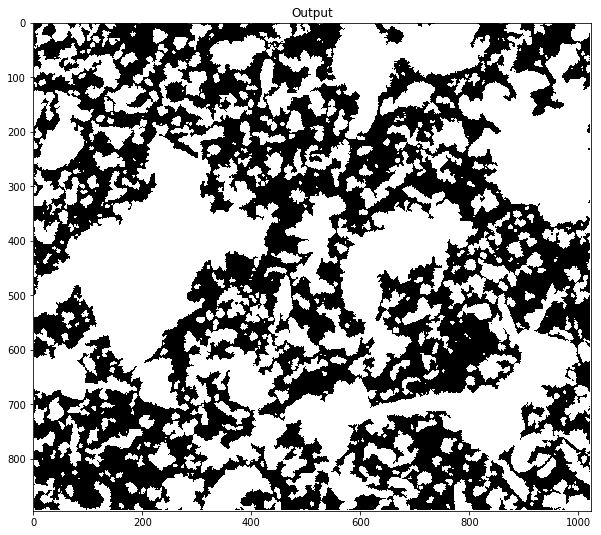

In [15]:
filled_img = ndimage.binary_fill_holes(binary_img)

eroded_img = ndimage.binary_erosion(filled_img)
reconstruct_img = ndimage.binary_propagation(eroded_img, mask=ndimage.filters.gaussian_filter(binary_img,10,order=2))
tmp = np.invert(reconstruct_img)
eroded_tmp = ndimage.binary_erosion(tmp)
GMM_reconstruct_final = np.invert(ndimage.binary_propagation(eroded_tmp, mask=ndimage.filters.gaussian_filter(tmp,10,order=2)))

plt.imshow(GMM_reconstruct_final, 'gray')
plt.title('Output')
plt.show()

Detected 489 grains.


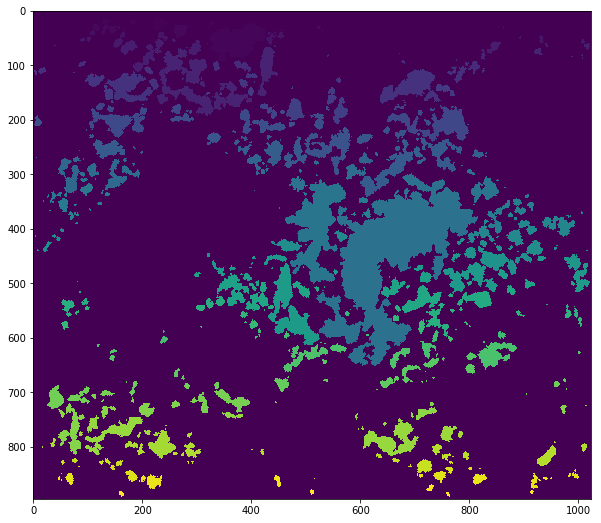

In [16]:
label_im, nb_labels = ndimage.label(GMM_reconstruct_final)
print("Detected {} grains.".format(nb_labels))
plt.imshow(label_im)        

So we have a nice separation of the data. If we can make this "general" so if we can feed it more pictures and the model holds up, this would be amazing. Let's have a look at the actual separation. After all the nice statistical models only matter, if the data looks good.

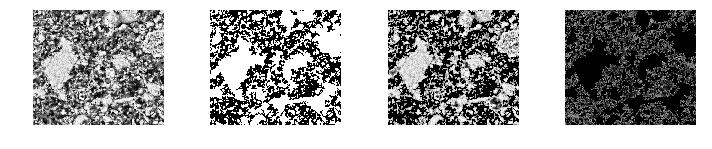

In [17]:
plt.subplot(141)
plt.imshow(bsem, cmap='gray')
plt.axis('off')
plt.subplot(142)
plt.imshow(GMM_reconstruct_final, cmap='gray')
plt.axis('off')
plt.subplot(143)
plt.imshow(bsem*GMM_reconstruct_final, cmap='gray')
plt.axis('off')
plt.subplot(144)
plt.imshow(bsem*np.invert(GMM_reconstruct_final), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig('GMM_segmentation_small.png', dpi = 200, bbox_inches='tight', pad_inches = 0)
plt.show()

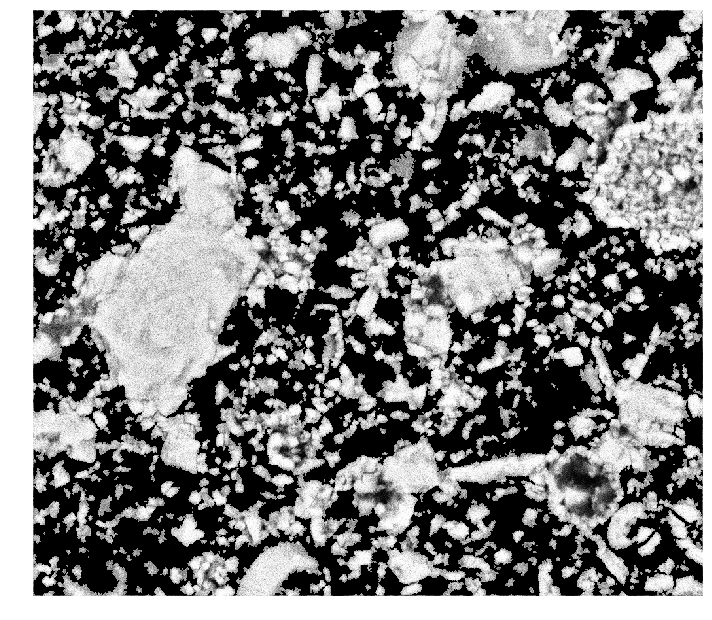

In [18]:
plt.imshow(bsem*GMM_reconstruct_final, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig('GMM_segmentation.png', dpi = 200, bbox_inches='tight', pad_inches = 0)

Nice. Shadows and textures of grains were not cut out. That is actually fantastic.

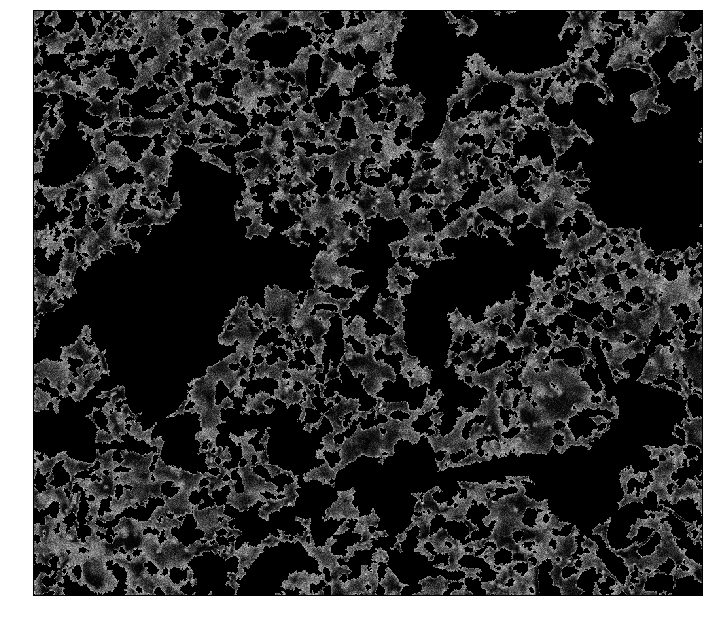

In [19]:
plt.imshow(bsem*np.invert(GMM_reconstruct_final),cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig('GMM_segmentation_out.png', dpi = 200, bbox_inches='tight', pad_inches = 0)

Not too much to see that is wrong per se. Couple of very small grains no one would have classified by hand either. Below is some stuff I already tried on the sizes and shape, this has to be extended, once you are happy with the separation.

## Some Granulometry

Let's check the porosity (compare it to He-porosity).

In [20]:
print("The porosity is {:.2f}%".format(100 * (1-(np.count_nonzero(GMM_reconstruct_final) /( GMM_reconstruct_final.shape[1] * GMM_reconstruct_final.shape[0])))))

The porosity is 44.25%


In [21]:
sizes = ndimage.sum(GMM_reconstruct_final, label_im, range(nb_labels + 1))
mean_vals = ndimage.sum(GMM_reconstruct_final, label_im, range(1, nb_labels + 1))

def disk_structure(n):
    struct = np.zeros((2 * n + 1, 2 * n + 1))
    x, y = np.indices((2 * n + 1, 2 * n + 1))
    mask = (x - n)**2 + (y - n)**2 <= n**2
    struct[mask] = 1
    return struct.astype(np.bool)


def granulometry(data, sizes=None):
    s = max(data.shape)
    if sizes is None:
        sizes = range(1, s//2, 2)
    granulo = [ndimage.binary_opening(data, \
            structure=disk_structure(n)).sum() for n in sizes]
    return granulo

In [22]:
grano_size = np.arange(2, 27, 2)
granulo = granulometry(GMM_reconstruct_final, grano_size)
opened = ndimage.binary_opening(GMM_reconstruct_final, structure=disk_structure(10))
opened_more = ndimage.binary_opening(GMM_reconstruct_final, structure=disk_structure(14))

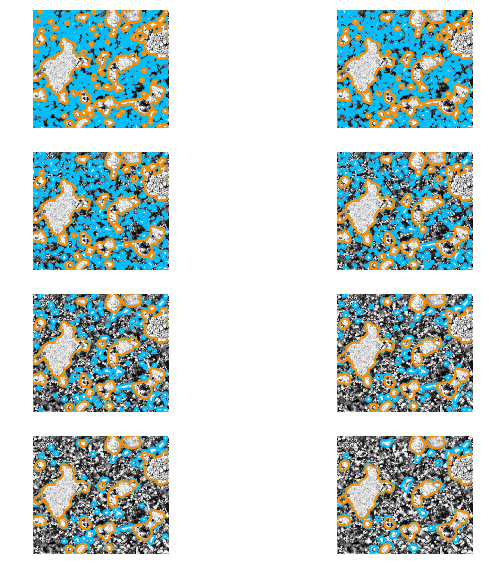

In [23]:
for q in range(8):
    plt.subplot(4,2,1+q)
    opened = ndimage.binary_opening(GMM_reconstruct_final, structure=disk_structure(grano_size[q]))
    opened_more = ndimage.binary_opening(GMM_reconstruct_final, structure=disk_structure(grano_size[q+5]))
    plt.imshow(bsem, cmap=plt.cm.gray)
    plt.contour(opened, [0.25], colors='deepskyblue', linewidths=2)
    plt.contour(opened_more, [0.25], colors='darkorange', linewidths=2)
    plt.axis('off')
plt.show()


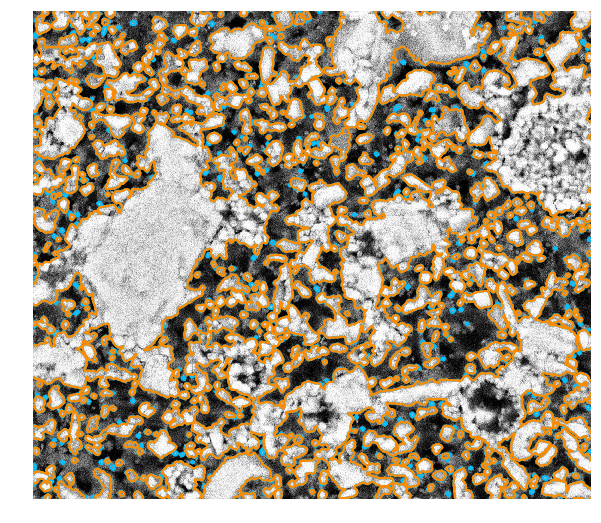

In [24]:
opened = ndimage.binary_opening(GMM_reconstruct_final, structure=disk_structure(2))
opened_more = ndimage.binary_opening(GMM_reconstruct_final, structure=disk_structure(3))
plt.imshow(bsem, cmap=plt.cm.gray)
plt.contour(opened, [0.1], colors='deepskyblue', linewidths=2)
plt.contour(opened_more, [0.1], colors='darkorange', linewidths=2)
plt.axis('off')
plt.show()


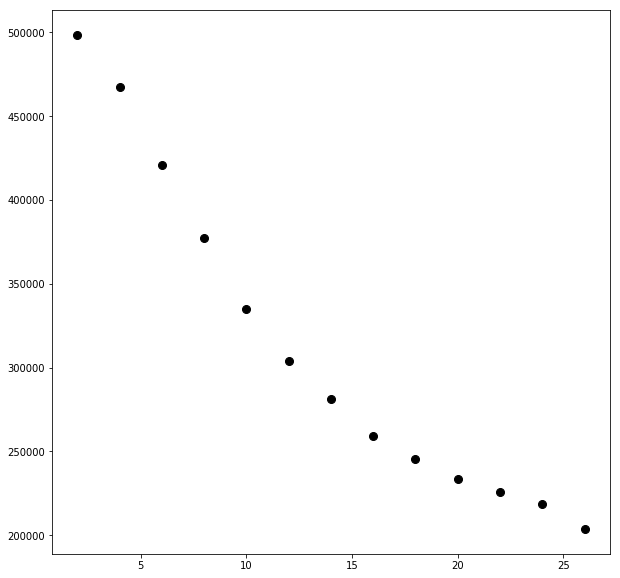

In [25]:
plt.plot(grano_size, granulo, 'ok', ms=8)
plt.show()

## Watershed Algorithm
Testing the standard watershed algorithm

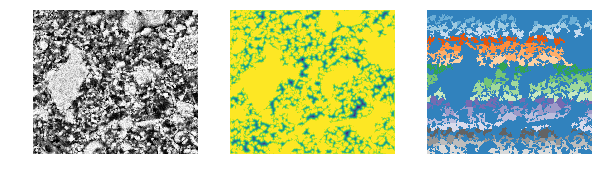

In [26]:

distance = ndimage.distance_transform_edt(np.invert(GMM_reconstruct_final))
local_maxi = peak_local_max(
    distance, indices=False, footprint=np.ones((13, 13)), labels=np.invert(GMM_reconstruct_final))
markers = ndimage.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=np.invert(GMM_reconstruct_final))

plt.subplot(131)
plt.imshow(bsem, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(132)
plt.imshow(-distance, interpolation='nearest')
plt.axis('off')
plt.subplot(133)
plt.imshow(labels, cmap='tab20c', interpolation='nearest')
plt.axis('off')

plt.show()

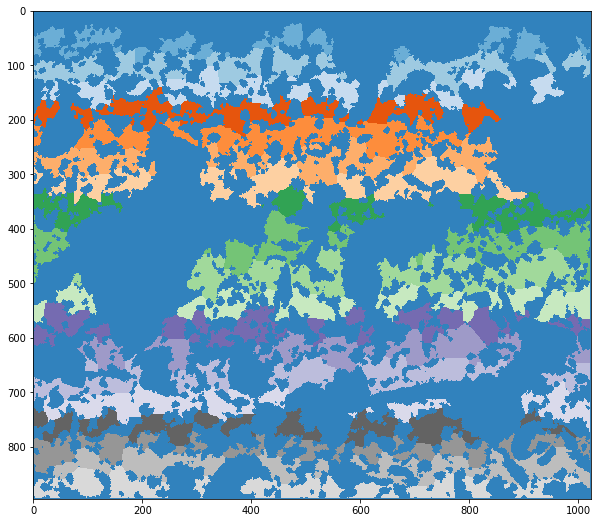

In [27]:
plt.imshow(labels, cmap='tab20c')